# 12wk-1: 순환신경망 (2) – RNN: `rNNCell`, `RNNCell`

최규빈  
2024-05-20

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/12wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xq0bBQn8ZP607mS0ZKI8Sg&si=-cQULuc2x7noftgE>

# 2. Import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
soft = torch.nn.Softmax(dim=1)

# 3. AbAcAd – 실패

## A. Data

`-` 데이터 정리

In [ ]:
txt = list('AbAcAd'*50)
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [ ]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,A,b
1,b,A
2,A,c
3,c,A
4,A,d


In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3})) #딕셔너리로 매핑 암기..
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))

In [ ]:
x[:8],y[:8]

(tensor([0, 1, 0, 2, 0, 3, 0, 1]), tensor([1, 0, 2, 0, 3, 0, 1, 0]))

## B. 풀이 – 실패

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4,2), #임베딩.. 2차원
    torch.nn.Tanh(),
    torch.nn.Linear(2,4) #원핫 인코딩 된 결과를 바람.. 4차원
)
ebdd,tanh,linr = net #언패킹..
ebdd.weight.data = ebdd.weight.data*0 +0.1 #가중치들 모두 0.1로 변경.
linr.weight.data = linr.weight.data*0 +0.1
linr.bias.data = linr.bias.data*0 +0.1
#
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
#---#
for epoc in range(200):
    # 1
    netout = net(x)
    # 2
    loss = loss_fn(netout,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

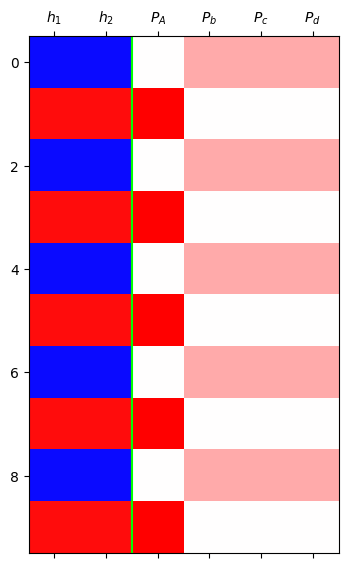

In [ ]:
h = tanh(ebdd(x))
yhat = soft(net(x))
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap="bwr",vmin=-1,vmax=1)
plt.axvline(1.5,color="lime")
plt.xticks(ticks=range(6),labels=[r"$h_1$",r"$h_2$",r"$P_A$",r"$P_b$",r"$P_c$",r"$P_d$"]);

-   망했음
-   왜?

`-` 일단 망한건 망한거고 분석을 위해서 숫자좀 체크하자.

In [ ]:
net(x)

tensor([[-3.8707,  3.6876,  3.6876,  3.6876],
        [ 5.4851, -4.9053, -4.9053, -4.9053],
        [-3.8707,  3.6876,  3.6876,  3.6876],
        ...,
        [-3.8707,  3.6876,  3.6876,  3.6876],
        [ 5.4851, -4.9053, -4.9053, -4.9053],
        [-3.8707,  3.6876,  3.6876,  3.6876]], grad_fn=<AddmmBackward0>)

## C. 실패한 풀이의 다른구현1

`-` B를 다른방식으로 구현해보자.

`-` 새로운 방식의 데이터 정리

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float() #원핫 인코딩 해버림.. 로스 게산을 위해 float화.
y = torch.nn.functional.one_hot(y).float()

`-` 사용자 정의 Hnet를 사용

In [ ]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2,bias=False)
        self.tanh = torch.nn.Tanh()
    def forward(self,X):
        h = self.tanh(self.i2h(X))
        return h
hnet = Hnet()
linr = torch.nn.Linear(2,4) #굳이 바깥에서...?
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1 #접근 방식이 언패킹(인덱싱)아닌걸 기억할것..
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1
#

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()),lr=0.1) #학습하고자 하는 weight들을 리스트로 쭉 집어넣으면 된다는 것 기억..
#---#
for epoc in range(200):
    # 1
    h = hnet(X)
    netout = linr(h)
    # 2
    loss = loss_fn(netout,y)
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

`-` 이것도 숫자좀 체크해보자.

In [ ]:
linr(hnet(X))

tensor([[-3.8707,  3.6876,  3.6876,  3.6876],
        [ 5.4851, -4.9053, -4.9053, -4.9053],
        [-3.8707,  3.6876,  3.6876,  3.6876],
        ...,
        [-3.8707,  3.6876,  3.6876,  3.6876],
        [ 5.4851, -4.9053, -4.9053, -4.9053],
        [-3.8707,  3.6876,  3.6876,  3.6876]], grad_fn=<AddmmBackward0>)

-   이전코드와 결과가 같음

## D. 실패한 풀이의 다른구현2

`# 예비학습` – 아래를 관찰하자.

In [ ]:
X = torch.tensor(
    [[1., 0., 0., 0.],
     [0., 1., 0., 0.]]
)
linr = torch.nn.Linear(4,2)

In [ ]:
linr(X)

tensor([[-0.6564,  0.2229],
        [-0.1968,  0.3221]], grad_fn=<AddmmBackward0>)

In [ ]:
linr(X[[0]]),linr(X[[1]]) #첫, 두번째 옵저베이션을 linr태움

(tensor([[-0.6564,  0.2229]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1968,  0.3221]], grad_fn=<AddmmBackward0>))

In [ ]:
linr(X[0]),linr(X[1]) #차원이 1,4로 반환 되어야 하는데 그냥 4 로 내보내줌... (사실 엄밀하진 않은데 그냥 계산 해주는 거임..)

(tensor([-0.6564,  0.2229], grad_fn=<ViewBackward0>),
 tensor([-0.1968,  0.3221], grad_fn=<ViewBackward0>))

`#`

`-` 또 다른방식의 구현

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [ ]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2,bias=False)
        self.tanh = torch.nn.Tanh()
    def forward(self,X):
        h = self.tanh(self.i2h(X))
        return h
hnet = Hnet()
linr = torch.nn.Linear(2,4)
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1
# 같은 Hnet..

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()),lr=0.1)
#---#
L = len(X) #타임시리즈 자료의 크기..
for epoc in range(200):
    # 1~2
    loss = 0
    for t in range(L):
        Xt,yt = X[t],y[t]
        ht = hnet(Xt) #하나씩 h값 계산
        ot = linr(ht) #하나씩 out 값 계산.
        loss = loss + loss_fn(ot,yt) #여기서 그냥 loss로 두면... 다 날라가고 299번 째 자료만 loss에 반영됨,,, loss들을 다 반영해서 계산하고 싶기 때문에 loss = loss + loss_fn() 꼴로 살려서 계산한 것..
    loss = loss/L
    # 3
    loss.backward()
    # 4
    optimizr.step()
    optimizr.zero_grad()

`-` 이것도 숫자좀 체크해보자.

In [ ]:
linr(hnet(X))

tensor([[-3.8817,  3.6988,  3.6988,  3.6988],
        [ 5.4775, -4.8976, -4.8976, -4.8976],
        [-3.8817,  3.6988,  3.6988,  3.6988],
        ...,
        [-3.8817,  3.6988,  3.6988,  3.6988],
        [ 5.4775, -4.8976, -4.8976, -4.8976],
        [-3.8817,  3.6988,  3.6988,  3.6988]], grad_fn=<AddmmBackward0>)

`-` 임베딩공간의 해석

In [ ]:
h = hnet(X) #X를 원 핫 인코딩 말고 또 다른 방법으로 표현한 것: h

In [ ]:
h.shape

torch.Size([299, 2])

In [ ]:
h.T.shape #두개로 언패킹 하면 [1,299] 씩 나눠 갖는다..

torch.Size([2, 299])

In [ ]:
h1,h2 = h.T.data #전치해서 언패킹 한 것..
# h1 = h[:,0].data
# h2 = h[:,1].data

In [ ]:
h1[::6] , h2[::6] #첫 'A'에 대한 h 숫자..

(tensor([-0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572]),
 tensor([-0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,
         -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572, -0.9572,

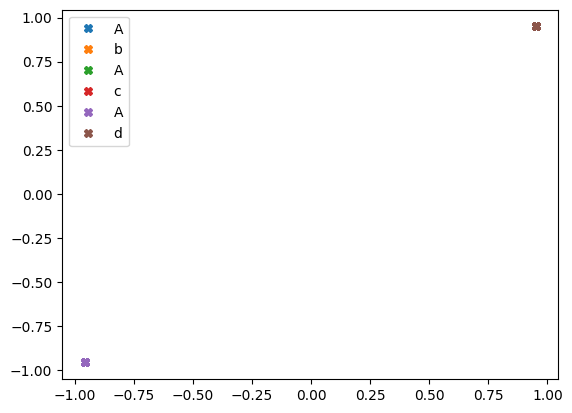

In [ ]:
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend() #각 문자열들을 나타낸 h를 임베딩 공간에서 시각화 한다. 문맥적으로 b,c,d를 동일문자 취급하고 잇다..

사실 잘못한 놈은 Hnet이다... 임베딩 자체가 잘못되어서 리니어가 잘 되지 않은거임!

> 임베딩공간의 해석? b,c,d는 사실상 같은 문자로 취급한다.

# 4. `AbAcAd` – 성공

## A. 순환신경망의 모티브

***(예비생각1) ${\boldsymbol h}$에 대한 이해***

`-` ${\boldsymbol h}$는 사실 문자열 “Abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
   ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
   ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
  ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보
${\boldsymbol x}$ 그 자체로 해석 할 수 있다.

***(예비생각2) [수백년전통을 이어가는
방법](https://www.joongang.co.kr/article/24087690#home)***

    “1리터에 500만원에 낙찰된 적 있습니다.”
    “2kg에 1억원 정도 추산됩니다.”
    “20여 종 종자장을 블렌딩해 100ml에 5000만원씩 분양 예정입니다.”

    모두 씨간장(종자장) 가격에 관한 실제 일화다.

    (중략...)

    위스키나 와인처럼 블렌딩을 하기도 한다.
    새로 담근 간장에 씨간장을 넣거나, 씨간장독에 햇간장을 넣어 맛을 유지하기도 한다.
    이를 겹장(또는 덧장)이라 한다.
    몇몇 종갓집에선 씨간장 잇기를 몇백 년째 해오고 있다.
    매년 새로 간장을 담가야 이어갈 수 있으니 불씨 꺼트리지 않는 것처럼 굉장히 어려운 일이다.
    이렇게 하는 이유는 집집마다 내려오는 고유 장맛을 잃지 않기 위함이다.
    씨간장이란 그만큼 소중한 주방의 자산이며 정체성이다.

덧장: 새로운간장을 만들때, 옛날간장을 섞어서 만듬

`*` 기존방식 -
$\text{콩물} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면?

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

점점 맛있는 간장계란밥이 탄생함

`*` 알고리즘의 편의상 아래와 같이 생각해도 무방

-   $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$,
  $\text{간장}_0=\text{맹물}$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? (콩물을
$x$로, 간장을 $h$로!!)

-   $\boldsymbol{x}_1, \boldsymbol{h}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
-   $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$
-   $\boldsymbol{x}_3, \boldsymbol{h}_2 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_3 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_3$

이제 우리가 배울것은 (1) “$\text{콩물}_{t}$”와 “$\text{간장}_{t-1}$”로
“$\text{간장}_t$”를 `숙성`하는 방법 (2) “$\text{간장}_t$”로
“$\text{간장계란밥}_t$를 `조리`하는 방법이다

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면
된다.

## B. 순환신경망 알고리즘

***`# 버전1`***

**step 1**: 일단 $\text{간장}_0(={\boldsymbol h}_0)$을 맹물로 초기화
한다. 즉 아래를 수행한다.

$${\boldsymbol h}_0 = [[0,0]]$$

이때 ${\boldsymbol h}_0 = [[0,0]]$ 은 이론상에서는 shape이 (1,2) 이지만
알고리즘 상에서는 shape 을 (2,)로 생각해도 무방하다.

**step 2**: $\text{콩물}_1(={\boldsymbol x}_1)$,
$\text{간장}_0(={\boldsymbol h}_0)$ 을 이용하여
$\text{간장}_1(={\boldsymbol h}_1)$을 숙성한다. 즉 아래를 수행한다.

$${\boldsymbol h}_1= \tanh({\boldsymbol x}_1{\bf W}_{ih}+{\boldsymbol h}_0{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$$

이때 변수들의 차원은 아래와 같다.

-   ${\boldsymbol x}_1$: (1,4) 이지만 (4,) 로 생각한다.
-   ${\boldsymbol h}_0$,${\boldsymbol h}_1$: (1,2) 이지만 (2,) 로
    생각한다.
-   ${\bf W}_{ih}$: (4,2) // ${\bf W}_{hh}$: (2,2) //
   ${\boldsymbol b}_{ih}$: (1,2) // ${\boldsymbol b}_{hh}$: (1,2) 로
    생각한다.

**step 3:** $\text{간장}_1$을 이용하여 $\text{간장계란밥}_1$을 만든다.
그리고 $\hat{\boldsymbol y}_1$을 만든다.

$${\boldsymbol o}_1= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$$

$$\hat{\boldsymbol y}_1 = \text{soft}({\boldsymbol o}_1)$$

**step 4**: $t=2,3,4,5,\dots,L$ 에 대하여 step2-3을 반복한다.

`#`

***`# 버전2`***

init $\boldsymbol{h}_0$

for $t$ in $1:L$

-   ${\boldsymbol h}_t= \tanh({\boldsymbol x}_t{\bf W}_{ih}+{\boldsymbol h}_{t-1}{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
-   ${\boldsymbol o}_t= {\bf W}_{ho}{\boldsymbol h}_t+{\boldsymbol b}_{ho}$
-   $\hat{\boldsymbol y}_t = \text{soft}({\boldsymbol o}_t)$

`#`

***`# 버전3`***

``` python
ht = [0,0]
for t in 1:T
    ht = tanh(linr(xt)+linr(ht))
    ot = linr(ht)
    yt_hat = soft(ot)
```

-   코드상으로는 $h_t$와 $h_{t-1}$의 구분이 교모하게 사라진다. (그래서
    오히려 좋아)

`#`

`-` 따라서 실질적인 전체코드는 아래와 같은 방식으로 구현할 수 있다.

``` python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?)
        linr2 = torch.nn.Linear(?,?)
        tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = tanh(lrnr1(Xt)+lrnr2(ht))
        return ht

init ht
rnncell = rNNCell()

for t in 1:L
    Xt, yt = X[t], y[t]
    ht = rnncell(Xt, ht)
    ot = linr(ht)
    loss = loss + loss_fn(ot, yt)
```


X의 디멘션은 (1,4) h의 디멘션은 (1,2).. 새로 갱신해야 하는 h의 디멘션 또한 (1,2).. 그려면 X에다가 (4,2) linear transform을 수행해야 한다.\
그렇게 강조하던 못박아 말하던 숙성은 사실 tanh 였다..


## C. 구현1 – rNNCell

`-` 데이터정리

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` 순환신경망으로 적합

In [ ]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) #차원이 2 인 임베딩 공간.
        self.h2h = torch.nn.Linear(2,2) #h를 h로 보내는 변환.
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = self.tanh(self.i2h(Xt)+self.h2h(ht)) #클래스를 활용하여 foward 재정의,
        return ht

torch.manual_seed(43052) # 시드고정해야만 답나옴 --> 임베딩공간이 부족하다는 의미 (사실상 6개의 문자니까!)
rnncell = rNNCell() # 너는 간장숙성을 담당해라 :net1
cook = torch.nn.Linear(2,4) # 너는 요리를 담당해라. (간장 계란밥을 만들겠다..) :net2

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+ list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(200):
    ## 1~2
    ht = torch.zeros(2) # 첫간장은 맹물 원래 (1,2)로 넣어야 하는데 (2)도 그냥 봐줌.
    loss = 0 #한번 t가 돌고 나면 loss를 0으로 초기화..
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

KeyboardInterrupt: 

`-` 결과 확인 및 시각화

In [ ]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water) # 올해 콩물 + 작년 간장(처음은 작년간장이 없으니까 물)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1]) #올해 콩물 + 작년 간장
yhat = soft(cook(h))
yhat

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

`-` yhat 값 분석

In [ ]:
yhat.data.numpy().round(3)[:10] #가장 큰 숫자가 해당 문자가 나올 확률이다..
#b가 나올 확률을 보면 0.946 -> 0.965 로 더 확률이 높아진 것을 볼 수 있는데.. 이를 "숙성"에 비유한 것이다... 학습을 할 수록 예측 성능이 좋아짐..

-   미세하지만 뒤로갈수록 좀 더 성능이 좋다.

`-` h1,h2 분석 (= 임베딩스페이스 분석)

In [ ]:
h1,h2 = h.T.data
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend()

#해석... A끼리는 1만큼 떨어져 있고 소문자들끼리는 약 0.25 씩 떨어져 있다..
#이는 해석하자면 A끼리는 1만큼씩 문맥적으로 차이가 있고, 소문자들은 그것보다 차이가 좀 더 적다는 것이다..
#상식적으로 A들이 각각 다음에 어떤 소문자가 오는 A인지 명확하게 구분만 된다면
#나머지 소문자들을 자동적으로 맞출 수 있다... 그래서 좀 더 A에 비중을 두고 학습하는 것이 바람직하다.

학습이 잘 되지 못한 이유를 따질 때,, 임베딩 공간에 잘 넣지 못한 hnet을 탓했었다.. 사실 이게 제일 중요함... 그래서 언어 모델은 언어학자의 역할이 제일 중요하다. 언어학자가 있다면... 해석이 용이하게 h가 형성됨.. 근데 그렇지 않고 컴퓨터가 스스로 hnet을 만들어야 한다면 학습은 잘 되어도 h의 해석이 쉽지 않을 수 있음. y가 잘 예측될 수 있는 방향으로 hnet을 적합하기 때문..

## D. 구현2 – RNNCell

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` 데이터정리

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` Net설계 및 가중치 설정 (구현1과 동일하도록 가중치 초기화)

In [ ]:
torch.manual_seed(43052)
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4)

In [ ]:
rnncell = torch.nn.RNNCell(4,2)
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.weight_hh.data = _rnncell.h2h.weight.data
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data #우리가 애써 사용자 정의로 만들었던 신경망이 자동으로 만들어져 있다.
#우리가 사용자 정의를 할 때 사용했던 초기 가중치들을 가져오는 코드임..

`-` 손실함수 및 옵티마이저 설정

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

`-` 학습

In [ ]:
L = len(X)
for epoc in range(200):
    ## 1~2
    ht = torch.zeros(2) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

`-` 결과확인

In [ ]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat

In [ ]:
yhat.data.numpy().round(2)

-   구현1과 같은 결과

# 5. HW: hello

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [ ]:
txt = list('hello'*100)
txt[:10]

['h', 'e', 'l', 'l', 'o', 'h', 'e', 'l', 'l', 'o']

In [ ]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,h,e
1,e,l
2,l,l
3,l,o
4,o,h


In [ ]:
x = torch.tensor(df_train.x.map({'h':0,'e':1,'l':2,'o':3}))
y = torch.tensor(df_train.y.map({'h':0,'e':1,'l':2,'o':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`(1)` `rNNCell`을 이용하여 학습하라. (적절한 은닉노드수를 설정할 것)


In [ ]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,3)
        self.h2h = torch.nn.Linear(3,3)
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = self.tanh(self.i2h(Xt)+self.h2h(ht))
        return ht
#torch.manual_seed(43052)
rnncell = rNNCell()
cook = torch.nn.Linear(3,4)
#
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+ list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(200):
    ## 1~2
    ht = torch.zeros(3) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h = torch.zeros(L,3)
water = torch.zeros(3)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat

tensor([[1.1381e-03, 9.9815e-01, 6.9989e-04, 1.0742e-05],
        [3.4387e-07, 4.9117e-04, 9.9950e-01, 7.4719e-06],
        [4.7343e-07, 3.0752e-05, 9.9869e-01, 1.2775e-03],
        ...,
        [4.2205e-07, 5.8095e-04, 9.9941e-01, 6.7444e-06],
        [2.9689e-07, 3.1251e-05, 9.9913e-01, 8.3531e-04],
        [7.5576e-04, 7.5769e-06, 3.8750e-04, 9.9885e-01]],
       grad_fn=<SoftmaxBackward0>)

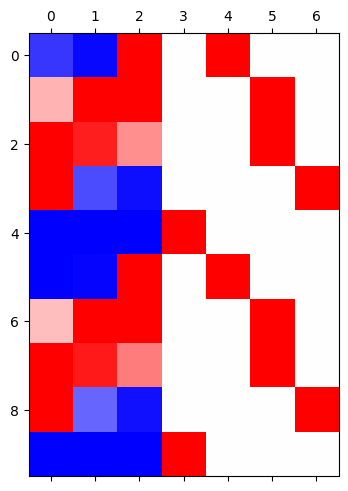

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
#plt.axvline(x=1.5,color='lime')
#plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);


`(2)` `torch.nn.RNNCell`을 이용하여 (1)의 결과를 재현하라.

In [ ]:
#
cook = torch.nn.Linear(3,4)
rnncell = torch.nn.RNNCell(4,3)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

In [ ]:
L = len(X)
for epoc in range(200):
    ## 1~2
    ht = torch.zeros(3) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h = torch.zeros(L,3)
water = torch.zeros(3)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat

tensor([[2.4326e-03, 9.9629e-01, 1.2981e-04, 1.1446e-03],
        [8.9267e-04, 7.7350e-04, 9.9832e-01, 1.3706e-05],
        [2.3762e-04, 3.8924e-06, 9.9892e-01, 8.4256e-04],
        ...,
        [1.0813e-03, 4.7814e-04, 9.9843e-01, 1.1063e-05],
        [2.5717e-04, 5.3482e-06, 9.9901e-01, 7.2475e-04],
        [4.1170e-04, 6.3314e-04, 3.4231e-04, 9.9861e-01]],
       grad_fn=<SoftmaxBackward0>)

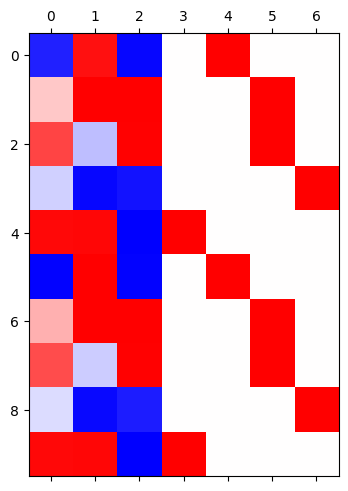

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
#plt.axvline(x=1.5,color='lime')
#plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);